## Function 1

Searching for Contamination Sources
This may sound simple because you only have a two-dimensional input, however it is a very difficult problem. It corresponds to trying to find the source of radiation in some square area. However, you can only detect the radiation once you are very close to it, meaning most of the readings will be zero. There are two sources, one is not too dangerous, so make sure you try to find both modes of the function.

1. Load the provided initial data.
2. Visualize the current data to understand its structure.
3. Fit a Gaussian Process (GP) surrogate model.
4. Use Bayesian optimization to suggest the next best point(s).

Week 7 08/05/25 - changed approach to exploit points around the 2 peaks that have been found. 


In [1]:
# update data weekly
import numpy as np
import os

# Function number (update this as needed)
function_id = 1  # change for f2, f3, etc.

# Load original data
inputs_path = f'function_{function_id}/initial_inputs.npy'
outputs_path = f'function_{function_id}/initial_outputs.npy'
inputs = np.load(inputs_path)
outputs = np.load(outputs_path)

# Load new data (replace this with your actual new submissions)
# Example: new 2D point with corresponding output
# week1: [0.42142, 0.42142] and 0.9999922493414768
# week2: [0.628629, 0.628629] and 1.9999236456410883
# week3_1t 0.5250245	0.5250245 and	1.112942370659196e-15
# week3_2f 0.618629	0.616627	and 1.116375828
# w4-1t: 0.432422	0.432422	and 0.558070014
# w4-2f: 0.706074	0.332894	and -6.391947129968789e-63
# w5-1t: 0.606161	0.610161	and 0.24250402
# w5-2f: 0.411421	0.411421	and 0.613669401794435
# w6-1t: 0.400021	0.425421	and 0.301994273233477
# w6-2f: 0.627628	0.628629 and 1.99597481964012
# w7-1t: 0.628937	0.629248 and 1.99683784549162
# w7-2f: 0.629397	0.629678 and 1.99027767671268
# w8-1t: 0.422422	0.421421 and 1.99683784549162
# w8-2f: 0.625629	0.629629 and 1.95413862398524
# w9-1t: 0.628639	0.628619 and 1.99992268567388
# W9-2f: 0.421421	0.422422 and 0.997778386329494
# w10-1t: 0.628629	0.629630 and 1.99426465641931
# w10-2f: 0.629997	0.623628 and 1.87765258920465

new_inputs = np.array([[0.629997, 0.623628]])
new_outputs = np.array([1.87765258920465])

# Concatenate new data to existing
updated_inputs = np.vstack([inputs, new_inputs])
updated_outputs = np.concatenate([outputs, new_outputs])
print("updated_inputs shape:", updated_inputs.shape)
print("updated_outputs shape:", updated_outputs.shape)
# Optionally: save backup copies before overwriting
np.save(f'function_{function_id}/backup_inputs.npy', inputs)
np.save(f'function_{function_id}/backup_outputs.npy', outputs)

# Save updated files
np.save(inputs_path, updated_inputs)
np.save(outputs_path, updated_outputs)

print("Updated data saved.")

updated_inputs shape: (28, 2)
updated_outputs shape: (28,)
Updated data saved.


Inputs shape: (28, 2)
Outputs shape: (28, 2)
[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.42142    0.42142   ]
 [0.628629   0.628629  ]
 [0.5250245  0.5250245 ]
 [0.618629   0.616627  ]
 [0.432422   0.432422  ]
 [0.706074   0.332894  ]
 [0.606161   0.610161  ]
 [0.411421   0.411421  ]
 [0.400021   0.425421  ]
 [0.627628   0.628629  ]
 [0.628937   0.629248  ]
 [0.629397   0.629678  ]
 [0.422422   0.421421  ]
 [0.625629   0.629629  ]
 [0.628639   0.628619  ]
 [0.421421   0.422422  ]
 [0.628629   0.62963   ]
 [0.629997   0.623628  ]] [ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  9.99992249e-001  1.99992365e+000
  1.11294237e-015  1.11637583e+000  5.58070014e

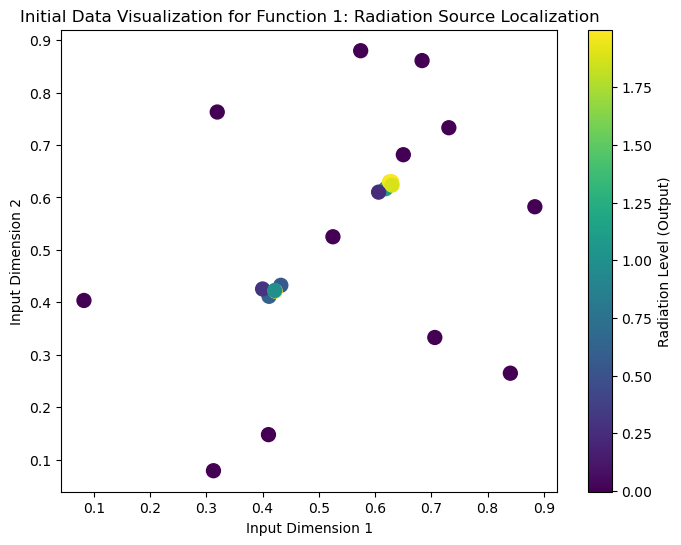

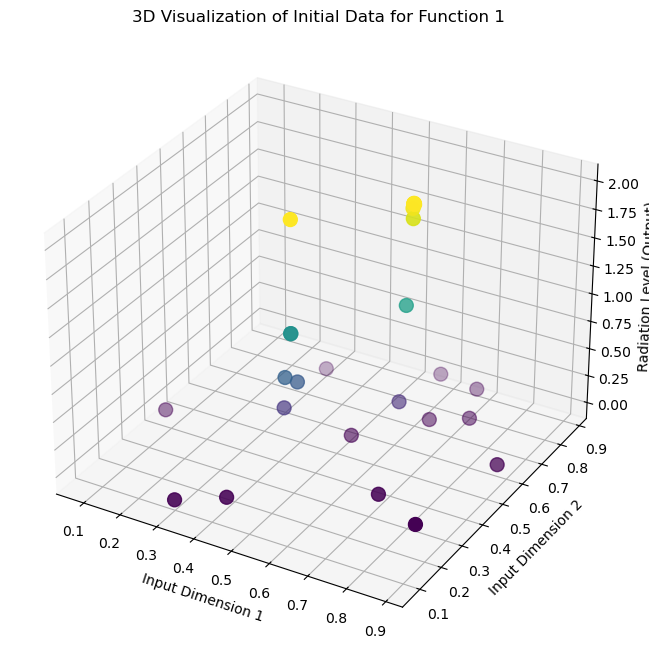

Bounds: [(0.390021, 0.639997), (0.401421, 0.639678)]
Suggested next best input point: [0.54758762 0.54931281]


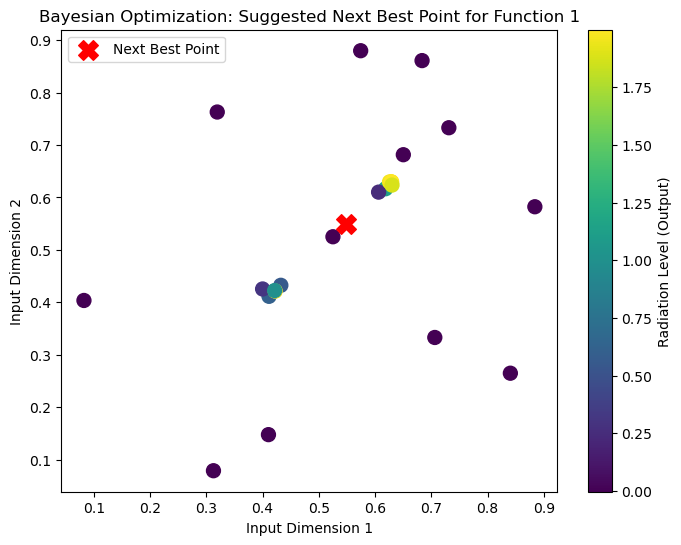

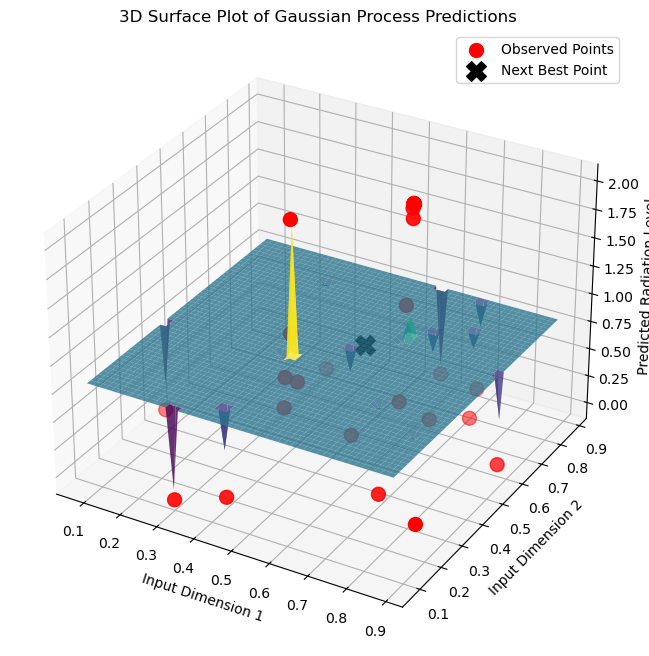

In [3]:
# Import necessary libraries
# used for week2 data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize

# Load initial data
inputs_f1 = np.load('function_1/initial_inputs.npy')
outputs_f1 = np.load('function_1/initial_outputs.npy')
print("Inputs shape:", inputs_f1.shape)
print("Outputs shape:", inputs_f1.shape)
print(inputs_f1, outputs_f1)
# Invert Y values for maximisation
# outputs_f1 = outputs_f1 * -1

# Step 1: Visualize initial data (2D scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f1[:, 0], inputs_f1[:, 1], c=outputs_f1, cmap='viridis', s=100)
plt.colorbar(label='Radiation Level (Output)')
plt.xlabel('Input Dimension 1')
plt.ylabel('Input Dimension 2')
plt.title('Initial Data Visualization for Function 1: Radiation Source Localization')
plt.show()

# Step 2: Visualize initial data (3D scatter plot)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inputs_f1[:, 0], inputs_f1[:, 1], outputs_f1, c=outputs_f1, cmap='viridis', s=100)
ax.set_xlabel('Input Dimension 1')
ax.set_ylabel('Input Dimension 2')
ax.set_zlabel('Radiation Level (Output)')
ax.set_title('3D Visualization of Initial Data for Function 1')
plt.show()

# Step 3: Define the function to suggest next best point using Bayesian Optimization within a radius
def suggest_next_point(inputs, outputs, threshold=0.01, radius=0.01):
    def gp_predict(x, gp):
        return -gp.predict(x.reshape(1, -1))[0] #-1 to maximise

    # Fit Gaussian Process surrogate model
    kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-10, 1e2), nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel,alpha=1e-2,normalize_y=True, n_restarts_optimizer=10)
    gp.fit(inputs, outputs)

    # Find points with elevated radiation levels
    elevated_points = inputs[outputs > threshold]

    # Define optimization bounds near elevated radiation points
    if elevated_points.size > 0:
        min_bounds = np.maximum(np.min(elevated_points, axis=0) - radius, np.min(inputs, axis=0))
        max_bounds = np.minimum(np.max(elevated_points, axis=0) + radius, np.max(inputs, axis=0))
    else:
        min_bounds = np.min(inputs, axis=0)
        max_bounds = np.max(inputs, axis=0)

    bounds = [(min_bounds[i], max_bounds[i]) for i in range(inputs.shape[1])]
    print("Bounds: "+str(bounds))
    # Optimize to find the next best query point
    result = minimize(gp_predict, np.mean(elevated_points, axis=0) if elevated_points.size > 0 else np.mean(inputs, axis=0), args=(gp,), bounds=bounds)
    return result.x, gp

# Step 4: Suggest the next best input location
next_best_point, gp_model = suggest_next_point(inputs_f1, outputs_f1)
print(f"Suggested next best input point: {next_best_point}")

# Visualize the suggested next best point
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f1[:, 0], inputs_f1[:, 1], c=outputs_f1, cmap='viridis', s=100)
plt.colorbar(label='Radiation Level (Output)')
plt.scatter(next_best_point[0], next_best_point[1], color='red', marker='X', s=200, label='Next Best Point')
plt.xlabel('Input Dimension 1')
plt.ylabel('Input Dimension 2')
plt.title('Bayesian Optimization: Suggested Next Best Point for Function 1')
plt.legend()
plt.show()

# Step 5: Visualize a 3D surface plot of the Gaussian Process predictions
x = np.linspace(np.min(inputs_f1[:, 0]), np.max(inputs_f1[:, 0]), 50)
y = np.linspace(np.min(inputs_f1[:, 1]), np.max(inputs_f1[:, 1]), 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T
Z = gp_model.predict(XY).reshape(X.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.scatter(inputs_f1[:, 0], inputs_f1[:, 1], outputs_f1, color='red', s=100, label='Observed Points')
ax.scatter(next_best_point[0], next_best_point[1], gp_model.predict(next_best_point.reshape(1, -1)), color='black', marker='X', s=200, label='Next Best Point')
ax.set_xlabel('Input Dimension 1')
ax.set_ylabel('Input Dimension 2')
ax.set_zlabel('Predicted Radiation Level')
ax.set_title('3D Surface Plot of Gaussian Process Predictions')
plt.legend()
plt.show()

# Suggested next best input point: [0.88388983 0.76222173]
# Suggested next best input point: [0.40948166 0.43346609]

🚧 But where can we improve?
1. Acquisition Function Choice
Expected Improvement (EI) or Upper Confidence Bound (UCB) aren’t ideal here because they:

Don’t sufficiently explore flat regions where the function may suddenly spike.

Might miss narrow optima if the current GP model is uncertain in those areas.

✅ Better options:
Probability of Improvement (PI) with a low threshold, to encourage exploring areas with even slight promise.

Thompson Sampling, which samples directly from the surrogate model’s posterior — good for sparse high-value regions.

Entropy Search / Predictive Entropy Search (if you have advanced tooling).

2. GP Kernel and Noise Assumptions
Use a smaller length scale in the Matern kernel, or even RBF kernel, to better model sharp transitions.

Consider heteroscedastic Gaussian processes if you suspect varying noise (although in this case, the noise is likely low or zero).

3. Batch / Focused Sampling
Rather than suggesting a single point, sample multiple points in regions where uncertainty is high.

Zoom in locally: focus search around elevated points already discovered.

4. Alternative Surrogate Models
If the GP struggles (especially with sharp peaks), try Tree Parzen Estimator (TPE) (used in Hyperopt).

Or use Bayesian Neural Networks (BNNs), which can generalize better over sharp spikes in high dimensions.

🔧 Suggested next steps (code-wise)
Switch EI to Thompson Sampling or PI with a low ξ.

Inputs shape: (26, 2)
Outputs shape: (26,)
[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.42142    0.42142   ]
 [0.628629   0.628629  ]
 [0.5250245  0.5250245 ]
 [0.618629   0.616627  ]
 [0.432422   0.432422  ]
 [0.706074   0.332894  ]
 [0.606161   0.610161  ]
 [0.411421   0.411421  ]
 [0.400021   0.425421  ]
 [0.627628   0.628629  ]
 [0.628937   0.629248  ]
 [0.629397   0.629678  ]
 [0.422422   0.421421  ]
 [0.625629   0.629629  ]
 [0.628639   0.628619  ]
 [0.421421   0.422422  ]] [ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  9.99992249e-001  1.99992365e+000
  1.11294237e-015  1.11637583e+000  5.58070014e-001 -6.39194713e-063
  2.42504020e-001  6.13669402e

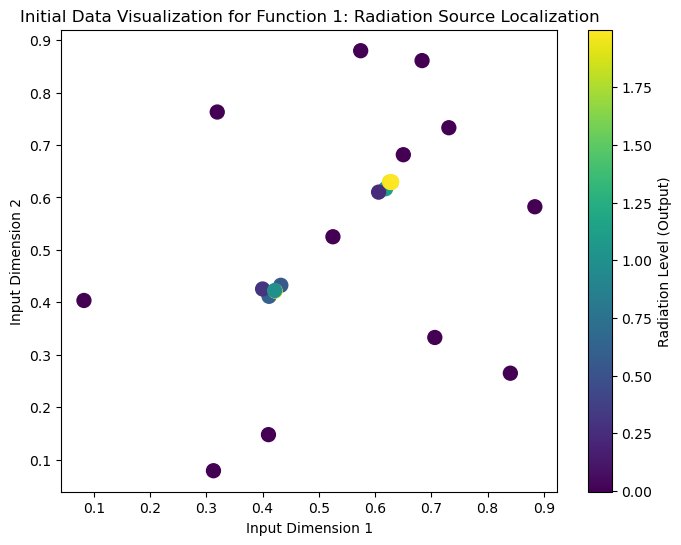

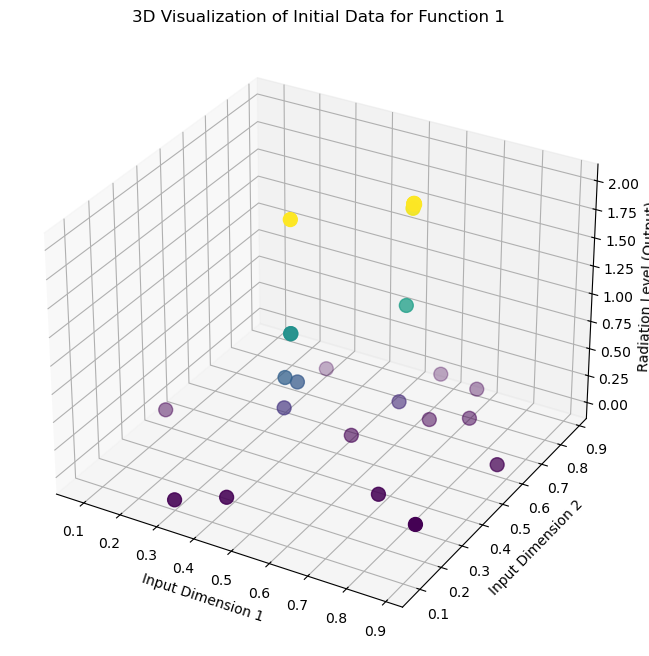

In [ ]:
# updated for thompson sampling
# used for week2 data
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Load initial data
inputs_f1 = np.load('function_1/initial_inputs.npy')
outputs_f1 = np.load('function_1/initial_outputs.npy')
print("Inputs shape:", inputs_f1.shape)
print("Outputs shape:", outputs_f1.shape)
print(inputs_f1, outputs_f1)
# Step 1: Visualize initial data (2D scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f1[:, 0], inputs_f1[:, 1], c=outputs_f1, cmap='viridis', s=100)
plt.colorbar(label='Radiation Level (Output)')
plt.xlabel('Input Dimension 1')
plt.ylabel('Input Dimension 2')
plt.title('Initial Data Visualization for Function 1: Radiation Source Localization')
plt.show()

# Step 2: Visualize initial data (3D scatter plot)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inputs_f1[:, 0], inputs_f1[:, 1], outputs_f1, c=outputs_f1, cmap='viridis', s=100)
ax.set_xlabel('Input Dimension 1')
ax.set_ylabel('Input Dimension 2')
ax.set_zlabel('Radiation Level (Output)')
ax.set_title('3D Visualization of Initial Data for Function 1')
plt.show()

# Step 3: Suggest next best point using Thompson Sampling
def suggest_next_point_thompson(inputs, outputs):
    # Fit Gaussian Process surrogate model
    kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-10, 1e2), nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(inputs, outputs)

    # Define candidate points across the input space
    grid_size = 100
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X_grid, Y_grid = np.meshgrid(x, y)
    XY = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    # Sample from the GP posterior
    sampled_y = gp.sample_y(XY, n_samples=1).ravel()

    # Choose the point with the highest sampled value
    best_idx = np.argmax(sampled_y)
    return XY[best_idx], gp

# Step 4: Suggest the next best input location
next_best_point, gp_model = suggest_next_point_thompson(inputs_f1, outputs_f1)
print(f"Suggested next best input point (Thompson Sampling): {next_best_point}")

# Visualize the suggested next best point
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f1[:, 0], inputs_f1[:, 1], c=outputs_f1, cmap='viridis', s=100)
plt.colorbar(label='Radiation Level (Output)')
plt.scatter(next_best_point[0], next_best_point[1], color='red', marker='X', s=200, label='Next Best Point')
plt.xlabel('Input Dimension 1')
plt.ylabel('Input Dimension 2')
plt.title('Thompson Sampling: Suggested Next Best Point for Function 1')
plt.legend()
plt.show()

# Step 5: Visualize a 3D surface plot of the Gaussian Process predictions
x = np.linspace(np.min(inputs_f1[:, 0]), np.max(inputs_f1[:, 0]), 50)
y = np.linspace(np.min(inputs_f1[:, 1]), np.max(inputs_f1[:, 1]), 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T
Z = gp_model.predict(XY).reshape(X.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.scatter(inputs_f1[:, 0], inputs_f1[:, 1], outputs_f1, color='red', s=100, label='Observed Points')
ax.scatter(next_best_point[0], next_best_point[1], gp_model.predict(next_best_point.reshape(1, -1)), color='black', marker='X', s=200, label='Next Best Point')
ax.set_xlabel('Input Dimension 1')
ax.set_ylabel('Input Dimension 2')
ax.set_zlabel('Predicted Radiation Level')
ax.set_title('3D Surface Plot of Gaussian Process Predictions (Thompson Sampling)')
plt.legend()
plt.show()


In [9]:
def function1(x1, x2):
        '''
        Sum of two EASOM functions: https://www.sfu.ca/~ssurjano/easom.html

        First one is rescaled by two, and optimum is shifted by 1.72 in x1
        Second one is simply shifted so that optimum lies at -pi and pi

        Therefore optimum lies at (pi + 1.72, pi) (after coordinate transformation)
        '''
        x1 = (x1 - 0.5)*40
        x2 = (x2 - 0.5)*40

        ea1 = np.cos(x1 - 2)*np.cos(x2 - 2)*np.exp(-(x1 - np.pi - 2)**2 - (x2 - np.pi -2)**2) * 2
        ea2 = np.cos(-x1) * np.cos(-x2) * np.exp(-(x1 + np.pi)**2 - (x2 + np.pi)**2)
        return ea1 + ea2

# check x1 x2
# Compute predicted outputs from the function
computed_outputs = np.array([function1(x[0], x[1]) for x in inputs_f1])

# Combine for display and comparison
comparison_df = pd.DataFrame({
    'Input X1': inputs_f1[:, 0],
    'Input X2': inputs_f1[:, 1],
    'Original Output': outputs_f1,
    'Function1 Output': computed_outputs
})

# Show as table and optional visual comparison
print(comparison_df)


# Create a dense grid
x1_vals = np.linspace(0, 1, 1000)
x2_vals = np.linspace(0, 1, 1000)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z = function1(X1, X2)

# Flatten the arrays
X1_flat = X1.ravel()
X2_flat = X2.ravel()
Z_flat = Z.ravel()

# Get indices of the top 10 values
top_indices = np.argsort(Z_flat)[-10:][::-1]  # Descending order

# Extract top 10 values and their coordinates
top_x1 = X1_flat[top_indices]
top_x2 = X2_flat[top_indices]
top_y = Z_flat[top_indices]

# Display results
print("Top 10 (x1, x2) pairs with highest function1 values:")
for i in range(10):
    print(f"{i+1:>2}: x1 = {top_x1[i]:.6f}, x2 = {top_x2[i]:.6f}, function1 = {top_y[i]:.6f}")

# Focus search around (0.421, 0.421), the approx inverse-transform of (-π, -π)
center_x = 0.421
radius = 0.02  # Tune this to zoom in more or less

# Mask values within radius of second peak
dist_to_second_peak = np.sqrt((X1_flat - center_x)**2 + (X2_flat - center_x)**2)
mask = dist_to_second_peak < radius

# Apply mask
Z_focus = Z_flat[mask]
X1_focus = X1_flat[mask]
X2_focus = X2_flat[mask]

# Get top 10 values
top_indices = np.argsort(Z_focus)[-10:][::-1]
top_x1 = X1_focus[top_indices]
top_x2 = X2_focus[top_indices]
top_y = Z_focus[top_indices]

# Display results
print("Top 10 (x1, x2) pairs near second Easom peak (around 0.421, 0.421):")
for i in range(10):
    print(f"{i+1:>2}: x1 = {top_x1[i]:.6f}, x2 = {top_x2[i]:.6f}, function1 = {top_y[i]:.6f}")


    Input X1  Input X2  Original Output  Function1 Output
0   0.319404  0.762959     1.322677e-79      1.322677e-79
1   0.574329  0.879898     1.033078e-46      1.033078e-46
2   0.731024  0.733000     7.710875e-16      7.710875e-16
3   0.840353  0.264732    3.341771e-124     3.341771e-124
4   0.650114  0.681526    -3.606063e-03     -3.606063e-03
5   0.410437  0.147554    -2.159249e-54     -2.159249e-54
6   0.312691  0.078723    -2.089093e-91     -2.089093e-91
7   0.683418  0.861057     2.535001e-40      2.535001e-40
8   0.082507  0.403488     3.606771e-81      3.606771e-81
9   0.883890  0.582254     6.229856e-48      6.229856e-48
10  0.421420  0.421420     9.999922e-01      9.999922e-01
11  0.628629  0.628629     1.999924e+00      1.999924e+00
12  0.525025  0.525025     1.112942e-15      1.113096e-15
13  0.618629  0.616627     1.116376e+00      1.116376e+00
14  0.432422  0.432422     5.580700e-01      5.580700e-01
15  0.706074  0.332894    -6.391947e-63     -6.391947e-63
16  0.606161  

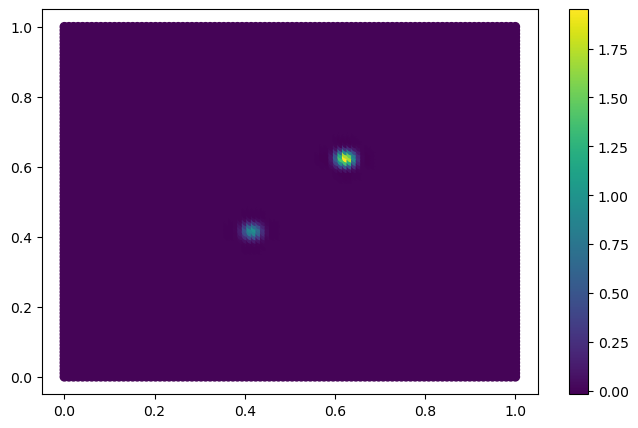

C:\Users\grant\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


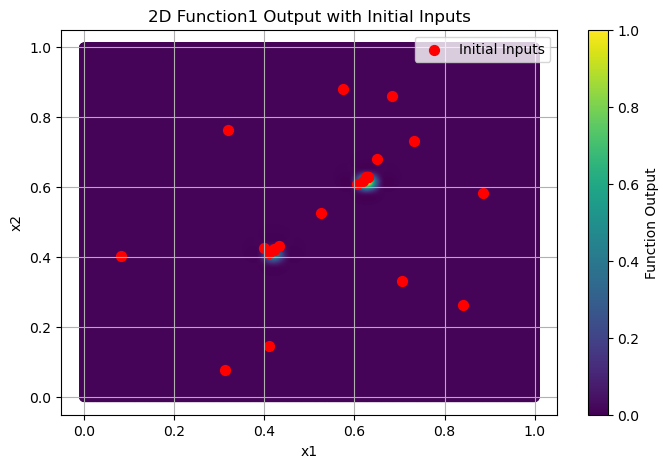

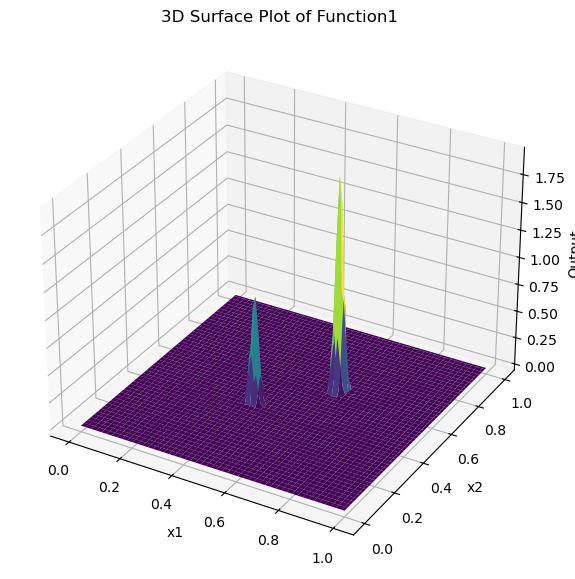

In [11]:
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)

X_real = []

Y_real = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_real.append([x1[i], x2[j]])
        Y_real.append(function1(x1[i], x2[j]))

X_real = np.array(X_real)

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X_real[:, 0], X_real[:, 1], c = Y_real)
plt.colorbar()

# 2D scatter plot with red dots for actual inputs
plt.figure(figsize=(8, 5))
plt.scatter(X1, X2, c=Z, cmap='viridis', alpha=0.8)
plt.scatter(inputs_f1[:, 0], inputs_f1[:, 1], color='red', s=50, label='Initial Inputs')
plt.colorbar(label='Function Output')
plt.title('2D Function1 Output with Initial Inputs')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)

# Compute function values
Z = function1(X1, X2)

# 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none')
ax.set_title('3D Surface Plot of Function1')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Output')
plt.show()

Inputs shape: (28, 2)
Outputs shape: (28,)


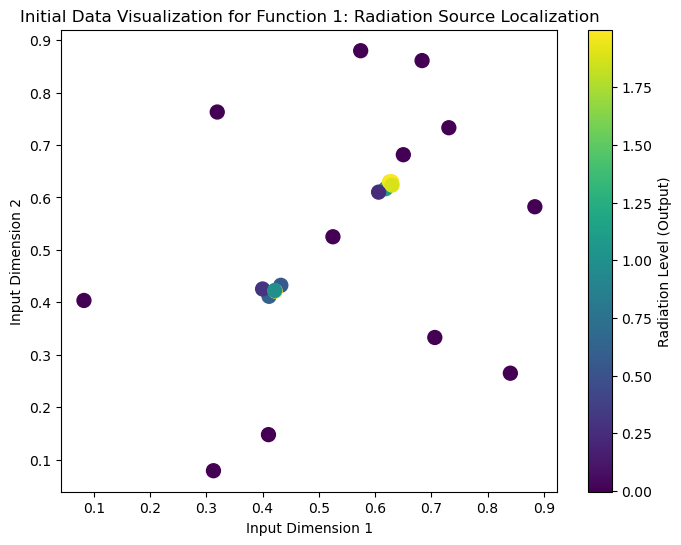

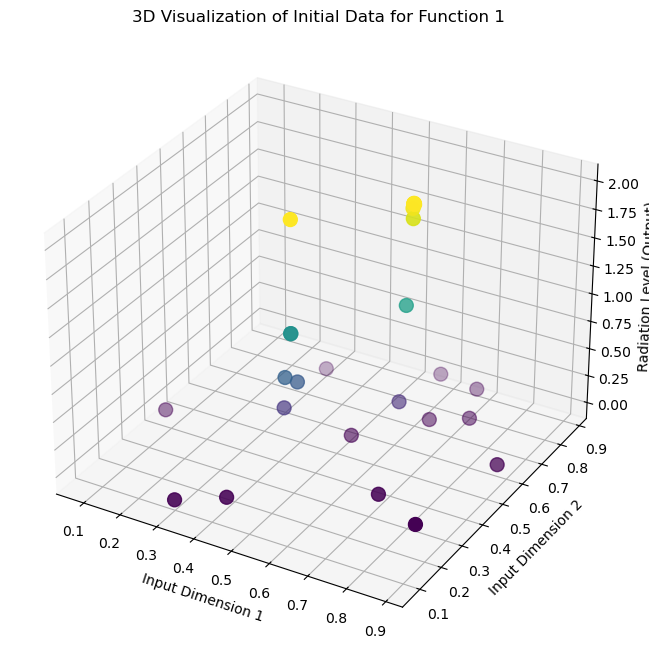

Bounds for peak at [0.628629 0.628629]: [(0.608629, 0.648629), (0.608629, 0.648629)]
Bounds for peak at [0.421421 0.421421]: [(0.401421, 0.441421), (0.401421, 0.441421)]
Suggested next point near peak 1: [0.62747385 0.62924296]
Suggested next point near peak 2: [0.42389248 0.42131776]


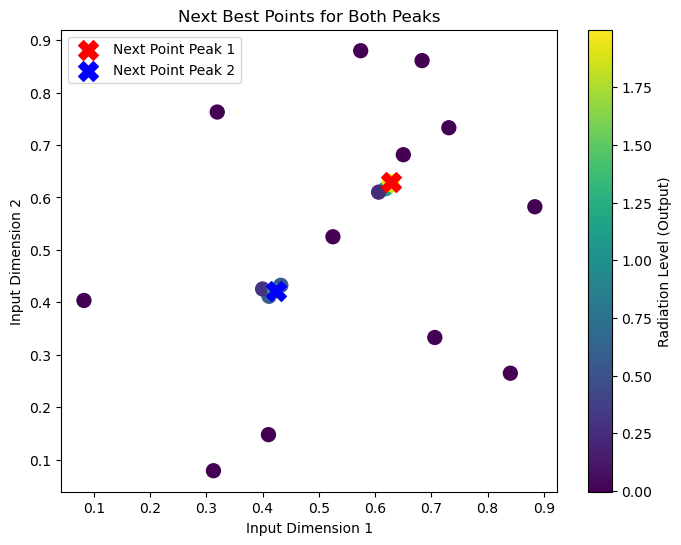

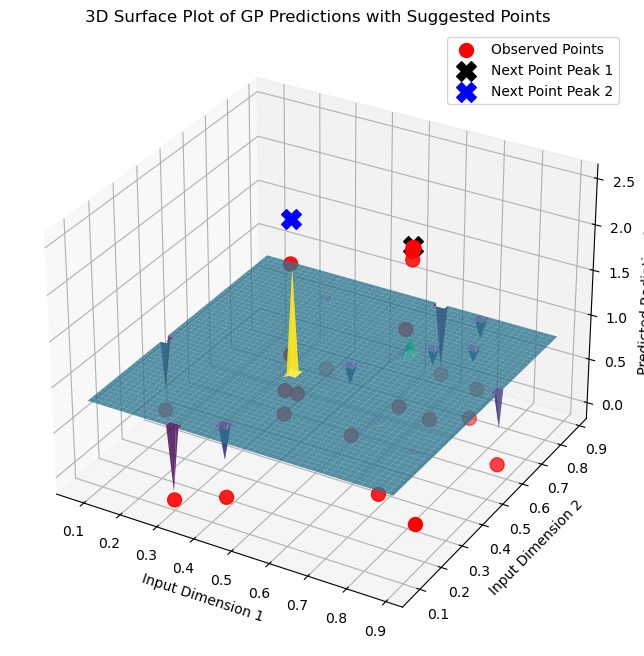

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize

# --------------------------
# Load initial data
# --------------------------
inputs_f1 = np.load('function_1/initial_inputs.npy')
outputs_f1 = np.load('function_1/initial_outputs.npy')

print("Inputs shape:", inputs_f1.shape)
print("Outputs shape:", outputs_f1.shape)

# --------------------------
# Step 1: Visualize initial data (2D scatter plot)
# --------------------------
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f1[:, 0], inputs_f1[:, 1], c=outputs_f1, cmap='viridis', s=100)
plt.colorbar(label='Radiation Level (Output)')
plt.xlabel('Input Dimension 1')
plt.ylabel('Input Dimension 2')
plt.title('Initial Data Visualization for Function 1: Radiation Source Localization')
plt.show()

# --------------------------
# Step 2: Visualize initial data (3D scatter plot)
# --------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inputs_f1[:, 0], inputs_f1[:, 1], outputs_f1, c=outputs_f1, cmap='viridis', s=100)
ax.set_xlabel('Input Dimension 1')
ax.set_ylabel('Input Dimension 2')
ax.set_zlabel('Radiation Level (Output)')
ax.set_title('3D Visualization of Initial Data for Function 1')
plt.show()

# --------------------------
# Step 3: Define function to suggest next best point near a given peak
# --------------------------
def suggest_next_point_near_peak(peak_center, inputs, outputs, radius=0.02):
    def gp_predict(x, gp):
        return -gp.predict(x.reshape(1, -1))[0]  # -1 to maximise

    # Fit GP model
    kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-10, 1e2), nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True, n_restarts_optimizer=10)
    gp.fit(inputs, outputs)

    # Define bounds around the specified peak center
    min_bounds = np.maximum(peak_center - radius, 0.0)
    max_bounds = np.minimum(peak_center + radius, 1.0)
    bounds = [(min_bounds[0], max_bounds[0]), (min_bounds[1], max_bounds[1])]

    print(f"Bounds for peak at {peak_center}: {bounds}")

    # Optimize within bounds
    result = minimize(
        gp_predict,
        x0=peak_center,
        args=(gp,),
        bounds=bounds
    )

    return result.x, gp

# --------------------------
# Step 4: Suggest next points near both peaks
# --------------------------
peak1 = np.array([0.628629, 0.628629])
peak2 = np.array([0.421421, 0.421421])

next_point_peak1, gp_model1 = suggest_next_point_near_peak(peak1, inputs_f1, outputs_f1)
next_point_peak2, gp_model2 = suggest_next_point_near_peak(peak2, inputs_f1, outputs_f1)

print(f"Suggested next point near peak 1: {next_point_peak1}")
print(f"Suggested next point near peak 2: {next_point_peak2}")

# --------------------------
# Step 5: Updated 2D plot showing both suggested points
# --------------------------
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f1[:, 0], inputs_f1[:, 1], c=outputs_f1, cmap='viridis', s=100)
plt.colorbar(label='Radiation Level (Output)')
plt.scatter(next_point_peak1[0], next_point_peak1[1], color='red', marker='X', s=200, label='Next Point Peak 1')
plt.scatter(next_point_peak2[0], next_point_peak2[1], color='blue', marker='X', s=200, label='Next Point Peak 2')
plt.xlabel('Input Dimension 1')
plt.ylabel('Input Dimension 2')
plt.title('Next Best Points for Both Peaks')
plt.legend()
plt.show()

# --------------------------
# Step 6: 3D surface plot showing both suggested points
# --------------------------
x = np.linspace(np.min(inputs_f1[:, 0]), np.max(inputs_f1[:, 0]), 50)
y = np.linspace(np.min(inputs_f1[:, 1]), np.max(inputs_f1[:, 1]), 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T

# Use gp_model1 for predictions (could also average both models for smoother plot)
Z = gp_model1.predict(XY).reshape(X.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.scatter(inputs_f1[:, 0], inputs_f1[:, 1], outputs_f1, color='red', s=100, label='Observed Points')
ax.scatter(next_point_peak1[0], next_point_peak1[1],
           gp_model1.predict(next_point_peak1.reshape(1, -1)),
           color='black', marker='X', s=200, label='Next Point Peak 1')
ax.scatter(next_point_peak2[0], next_point_peak2[1],
           gp_model1.predict(next_point_peak2.reshape(1, -1)),
           color='blue', marker='X', s=200, label='Next Point Peak 2')
ax.set_xlabel('Input Dimension 1')
ax.set_ylabel('Input Dimension 2')
ax.set_zlabel('Predicted Radiation Level')
ax.set_title('3D Surface Plot of GP Predictions with Suggested Points')
plt.legend()
plt.show()
